In [1]:
@file:DependsOnMaven("net.imagej:ij:1.51g")

In [2]:
@file:DependsOnMaven("net.imglib2:imglib2:3.2.1")

In [3]:
@file:DependsOnMaven("sc.fiji:z_spacing:1.0.3-SNAPSHOT")

In [4]:
@file:DependsOnMaven("de.hanslovsky:z_spacing-experiments:0.0.1-SNAPSHOT")

In [5]:
@file:DependsOnMaven("net.imglib2:imglib2-ij:2.0.0-beta-35")

In [6]:
@file:DependsOnMaven("net.imglib2:imglib2-realtransform:2.0.0-beta-34")

In [7]:
import java.io.ByteArrayOutputStream;
import java.io.File;
import java.util.stream.IntStream;

import javax.imageio.ImageIO;
import javax.xml.bind.DatatypeConverter;

import org.janelia.thickness.inference.InferFromMatrix;
import org.janelia.thickness.inference.Options;
import org.janelia.thickness.inference.fits.GlobalCorrelationFitAverage;
import org.janelia.thickness.lut.LUTRealTransform;

import ij.ImageJ;
import ij.ImagePlus;
import ij.io.FileSaver;
import ij.process.FloatProcessor;

import net.imglib2.RandomAccessibleInterval;
import net.imglib2.converter.Converter;
import net.imglib2.converter.Converters;
import net.imglib2.converter.RealARGBConverter;
import net.imglib2.img.array.ArrayImg;
import net.imglib2.img.array.ArrayImgs;
import net.imglib2.img.basictypeaccess.array.FloatArray;
import net.imglib2.img.display.imagej.ImageJFunctions;
import net.imglib2.interpolation.randomaccess.NLinearInterpolatorFactory;
import net.imglib2.realtransform.RealViews;
import net.imglib2.type.numeric.ARGBType;
import net.imglib2.type.numeric.NumericType;
import net.imglib2.type.numeric.real.FloatType;
import net.imglib2.view.IntervalView;
import net.imglib2.view.Views;

import de.hanslovsky.zspacing.experiments.wipeout.WipeMatrix;

In [8]:
fun< T : NumericType<T> > toBase64(ra: RandomAccessibleInterval< T >): Pair<String, Any> {
    val os = ByteArrayOutputStream();
    val bi = ImageJFunctions.wrap( ra, "" ).duplicate().getBufferedImage();
    ImageIO.write(bi, "png", os);
    val str = DatatypeConverter.printBase64Binary(os.toByteArray());
    val mime = "image/png";
    return mime to str;
}

In [9]:
val o = Options.generateDefaultOptions();
o.comparisonRange = 50;
o.nIterations = 100;
o.withReorder = false;
o.shiftProportion = 0.6;
o.minimumSectionThickness = 1e-9;
o.regularizationType = InferFromMatrix.RegularizationType.BORDER;
o.scalingFactorRegularizerWeight = 0.1;
o.coordinateUpdateRegularizerWeight = 0.0;
o.scalingFactorEstimationIterations = 10;
o.forceMonotonicity = true; // very important here!

val matrixPath = "https://github.com/hanslovsky/z-spacing-experiments/raw/master/resources/matrix.tif";
val wipeStart = 200;
val wipeStop = 300;

In [10]:
val fp1 = ImagePlus( matrixPath ).getProcessor().convertToFloatProcessor();
val fp2 = ImagePlus( matrixPath ).getProcessor().convertToFloatProcessor();
val w = fp1.getWidth();
val h = fp1.getHeight();

WipeMatrix.wipe( fp2, o.comparisonRange, wipeStart, wipeStop );

val m1 = ArrayImgs.floats( fp1.getPixels() as FloatArray, w.toLong(), h.toLong() );
val m2 = ArrayImgs.floats( fp2.getPixels() as FloatArray, w.toLong(), h.toLong() );

val conv = RealARGBConverter<FloatType>();

val c1 = Converters.convert( m1 as RandomAccessibleInterval<FloatType>, conv, ARGBType() );
val c2 = Converters.convert( m2 as RandomAccessibleInterval<FloatType>, conv, ARGBType() );

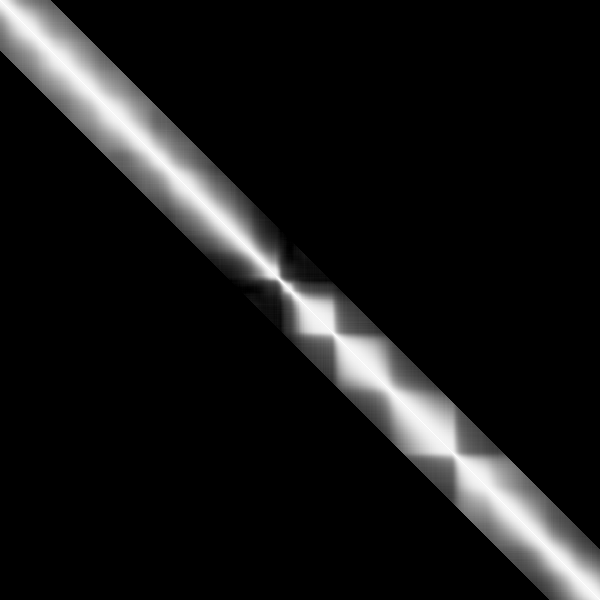

In [11]:
resultOf( toBase64( c1 ) )

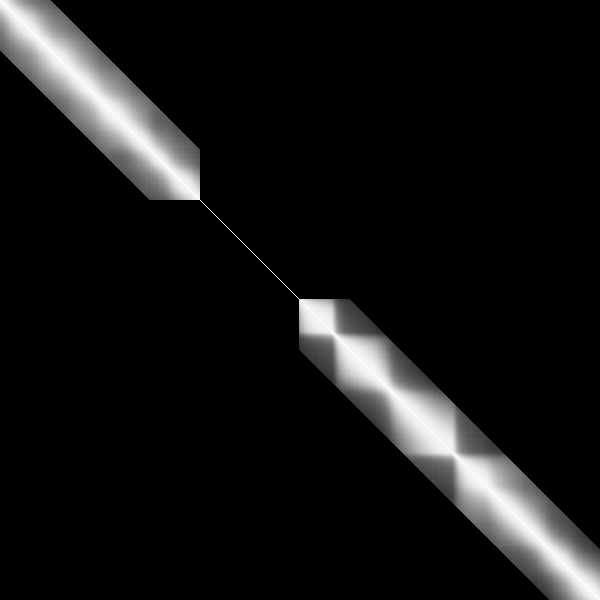

In [12]:
resultOf( toBase64( c2 ) )

In [13]:
val inf = InferFromMatrix( GlobalCorrelationFitAverage() );

val startingCoordinates = IntStream.range( 0, w ).mapToDouble( {  i -> i.toDouble() } ).toArray();

print("Running inference...\t");
val t1 = inf.estimateZCoordinates( m1, startingCoordinates.clone(), o );
val t2 = inf.estimateZCoordinates( m2, startingCoordinates.clone(), o );
println("Done")

Running inference...	Done


In [14]:
val tf1 = LUTRealTransform( t1, 2, 2 );
val tf2 = LUTRealTransform( t2, 2, 2 );

val fac = NLinearInterpolatorFactory<FloatType>();
val oob = FloatType( Float.NaN );

val o1 = Views.interval( Views.raster( RealViews.transform( Views.interpolate( Views.extendValue( m1, oob ), fac ), tf1 ) ), m1 );
val o2 = Views.interval( Views.raster( RealViews.transform( Views.interpolate( Views.extendValue( m1, oob ), fac ), tf2 ) ), m2 );
val o3 = Views.interval( Views.raster( RealViews.transform( Views.interpolate( Views.extendValue( m2, oob ), fac ), tf2 ) ), m2 );

val cc1 = Converters.convert( o1 as RandomAccessibleInterval<FloatType>, conv, ARGBType() );
val cc2 = Converters.convert( o2 as RandomAccessibleInterval<FloatType>, conv, ARGBType() );
val cc3 = Converters.convert( o3 as RandomAccessibleInterval<FloatType>, conv, ARGBType() );

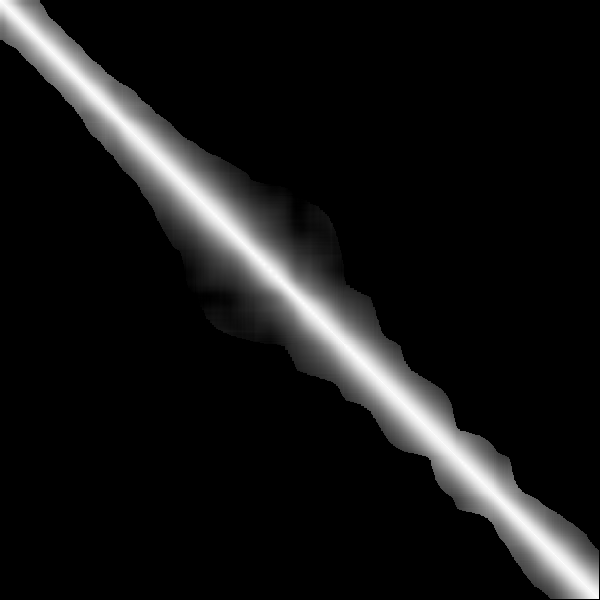

In [15]:
resultOf( toBase64( cc1 ) )

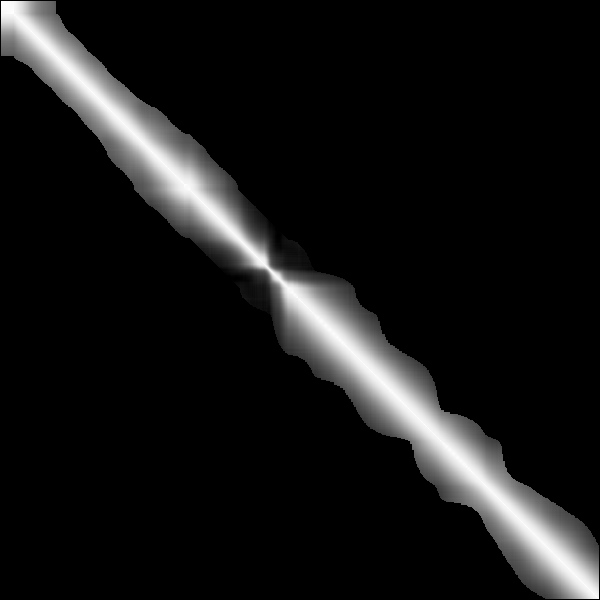

In [16]:
resultOf( toBase64( cc2 ) )

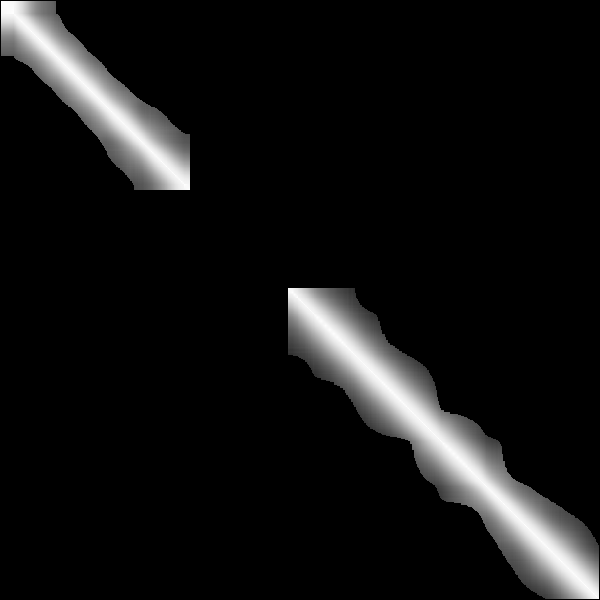

In [17]:
resultOf( toBase64( cc3 ) )